In [3]:
import os
import glob

import pandas as pd
import numpy as np
import scipy as sp
import scipy.sparse


import tqdm
from tqdm._tqdm_notebook import tqdm_notebook

import gc

from joblib import Parallel, delayed

import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.preprocessing import LabelEncoder
from sklearn.cluster import SpectralClustering
from sklearn.decomposition import LatentDirichletAllocation

import gensim
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from gensim.models.word2vec import Word2Vec

import pickle

from collections import defaultdict

from glove import Corpus, Glove

In [4]:
from utils import *

In [5]:
seed_everything(42)

In [9]:
tqdm_notebook.pandas()

In [6]:
input_path = 'input/'

TRAIN_TEXTS = os.path.join(input_path, 'texts', 'textsTrain')
TRAIN_META = os.path.join(input_path, 'textsTrain')

In [7]:
train_meta = read_metadata(TRAIN_META)
train_texts = read_texts(TRAIN_TEXTS)

In [10]:
train_texts['preprocessed'] = train_texts['preprocessed'].progress_apply(lambda seq: [convert_single(w) for w in seq])

In [12]:
train_meta['liked'] = train_meta['feedback'].progress_apply(lambda f: 'Liked' in f)

In [14]:
train_meta['instanceId_userId'] = LabelEncoder().fit_transform(train_meta['instanceId_userId'])
train_meta['instanceId_objectId'] = LabelEncoder().fit_transform(train_meta['instanceId_objectId'])

In [18]:
like_shape = train_meta['instanceId_userId'].max() + 1, train_meta['instanceId_objectId'].max() + 1
like_matrix = sp.sparse.lil_matrix(like_shape, dtype=np.uint8)

for idx, (uid, oid, liked) in enumerate(tqdm.tqdm_notebook(train_meta[['instanceId_userId', 'instanceId_objectId', 'liked']].values)):
    if liked:
        like_matrix[uid, oid] = 1

like_matrix = like_matrix.tocsr()

In [28]:
likes_sumed = np.array(like_matrix.sum(axis=1)).flatten()

In [40]:
# As we can see, there is a little information about user likes
# Moreover, 65% of users did not like any posts in training set
sum(likes_sumed < 10)/len(likes_sumed), sum(likes_sumed == 0)/len(likes_sumed)

(0.9929081667300919, 0.6500126209723402)

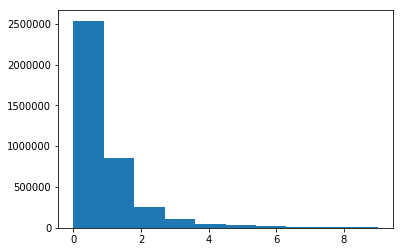

In [36]:
_ = plt.hist(likes_sumed[likes_sumed < 10])

In [41]:
counter = defaultdict(int)

for seq in tqdm.tqdm_notebook(train_texts.preprocessed):
    for w in seq:
        counter[w] += 1

In [42]:
counts = np.array(list(counter.values()))

In [44]:
threshold_vals = np.arange(10)
yvals = [sum(counts > t)/len(counts) for t in threshold_vals]

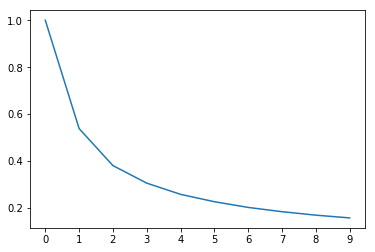

In [50]:
# how many words will we exclude if we will take only words with frequency > x?
plt.plot(threshold_vals, yvals)
_ = plt.xticks(threshold_vals)

In [29]:
# to learn embeddings for unknown words we can replace words that are out of dictionary with some "uknown" token
train_texts['filtered_unk'] = train_texts['preprocessed'].progress_apply(lambda seq: [w if counter[w] > 3 else '<unk>' for w in seq ])

In [30]:
corpus = Corpus() 
corpus.fit(train_texts.filtered_unk, window=5)

In [31]:
print('Learning glove embeddings...')
glove = Glove(no_components=300, learning_rate=0.05)
 
glove.fit(corpus.matrix, epochs=30, no_threads=16, verbose=True)
glove.add_dictionary(corpus.dictionary)

model_name = 'glove_300_mc4_unk.model'
model_path = os.path.join('embeddings', model_name)
glove.save(model_path)

Learning glove embeddings...
Performing 30 training epochs with 16 threads
Epoch 0
Epoch 1
Epoch 2
Epoch 3
Epoch 4
Epoch 5
Epoch 6
Epoch 7
Epoch 8
Epoch 9
Epoch 10
Epoch 11
Epoch 12
Epoch 13
Epoch 14
Epoch 15
Epoch 16
Epoch 17
Epoch 18
Epoch 19
Epoch 20
Epoch 21
Epoch 22
Epoch 23
Epoch 24
Epoch 25
Epoch 26
Epoch 27
Epoch 28
Epoch 29
